### Utility Functions

In [97]:
import numpy as np
import scipy.special as sp
import os
import copy
import heapq
import json

def find_or_create(dirname):
    if not os.path.isdir(dirname):
        try:
            os.makedirs(dirname)
        except:
            print("Cannot create directory : " + dirname)
            return False
    return True

'''
def load_txt(filename):
    if os.path.isfile(filename):
        x = np.loadtxt(filename)
        ndim = int(x[0])
        shape = np.asarray(x[1:ndim+1], dtype=int)
        x = np.reshape(x[ndim+1:], shape, order='F')
        return x
    else:
        print("load_txt error: file not found: " + filename)
        return np.ndarray([])

def save_txt(filename, x, fmt='%.8f'):
    y = np.asarray(x)
    data = np.concatenate(([y.ndim], y.shape, y.reshape(np.product(y.shape), order='F')))
    with open(filename, 'wb') as f:
        np.savetxt(f, data, fmt=fmt)
'''   


def load_txt(filename):
    X = np.loadtxt(filename)
    dim = int(X[0]);
    size = []
    for i in range(dim):
        size.append(int(X[i+1]));    
    X = np.reshape(X[dim+1:], size, order='F')
    return X;
        
def save_txt(filename, X, fmt = '%.8f'):
    with open(filename, 'w') as f:
        y = np.asarray(X)
        dim = len(y.shape)
        f.write('%d\n' % dim)
        for i in range(dim):
            f.write('%d\n' % y.shape[i])
        temp = y.reshape(np.product(y.shape), order='F')
        for num in temp:
            f.write(str(num)+"\n")
        # np.savetxt(f, temp, fmt = format)
        
        
def normalize(x):
    sum_x = np.sum(x)
    return np.asarray(x) / sum_x


def normalize_exp(x):
    return normalize(np.exp(x - np.max(x)))


def log_sum_exp(x):
    max_x = np.max(x)
    return max_x + np.log(np.sum(np.exp(x-max_x)))


def psi(x):
    return sp.digamma(x)


def inv_psi(y):
    x = (np.exp(y) + 0.5) * (y > -2.22) + (-1 / (y + 0.577215)) * (y <= -2.22)
    for i in range(5):
        x = x - ((sp.digamma(x) - y) / sp.polygamma(1, x))
    return x


def gammaln(x):
    return sp.gammaln(x)


class Data:
    def __init__(self, s=(), h=(), v=()):
        self.s = np.asarray(s)
        self.h = np.asarray(h)
        self.v = np.asarray(v)

    def save(self, dirname):
        find_or_create(dirname)
        if self.s.size > 0:
            save_txt(dirname + '/cps.txt', self.s, fmt='%d')
        if self.h.size > 0:
            save_txt(dirname + '/states.txt', self.h, fmt='%.6f')
        if self.v.size > 0:
            save_txt(dirname + '/obs.txt', self.v, fmt='%.6f')

    @classmethod
    def load(cls, dirname):
        data = cls()
        filename = dirname + '/cps.txt'
        if os.path.isfile(filename):
            data.s = load_txt(filename)
        filename = dirname + '/states.txt'
        if os.path.isfile(filename):
            data.h = load_txt(filename)
        filename = dirname + '/obs.txt'
        if os.path.isfile(filename):
            data.v = load_txt(filename)
        return data


class Result:
    def __init__(self):
        self.cpp = []
        self.mean = []
        self.ll = []

    def save(self, dirname):
        find_or_create(dirname)
        if len(self.mean) > 0:
            save_txt(dirname + '/mean.txt', self.mean, fmt='%.6f')
        if len(self.cpp) > 0:
            save_txt(dirname + '/cpp.txt', self.cpp, fmt='%.6f')
        if len(self.ll) > 0:
            save_txt(dirname + '/ll.txt', self.ll, fmt='%.6f')
            
    @classmethod
    def load(cls, dirname):
        result = cls()
        filename = dirname + '/cpp.txt'
        if os.path.isfile(filename):
            result.cpp = load_txt(filename)
        filename = dirname + '/mean.txt'
        if os.path.isfile(filename):
            result.mean = load_txt(filename)
        filename = dirname + '/ll.txt'
        if os.path.isfile(filename):
            result.ll = load_txt(filename)
        return result

### Visualization 

In [107]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import sys

%matplotlib inline

def visualize_data(dirname, m, n):
    data = Data.load(dirname)
    t = data.v.shape[1]
    print(t)
    if m > 0:
        fig = plt.figure(figsize=(12, 4))
        ax = fig.gca()
        ax.pcolormesh(data.v[0:m, :], cmap=plt.cm.Greys)
        ax.vlines(np.arange(0, t), 0, data.s * m, colors='r', linestyles='-', linewidth=2)
        ax.legend(['change points'])
    if n > 0:
        fig = plt.figure(figsize=(12, 4))
        gs = gridspec.GridSpec(n, 1, height_ratios=np.ones(n))
        for i in range(n):
            ax = plt.subplot(gs[i])
            y = data.v[m + i, :]
            y_lim_max = np.max(y) * 1.1
            # ax.plot(range(t), y, 'b-')
            ax.vlines(np.arange(t), np.zeros(t), y)
            ax.vlines(np.arange(0, t), 0, data.s * y_lim_max, colors='r', linestyles='-', linewidth=2)
            ax.set_ylim([0, y_lim_max])
    plt.show()

### Potential

In [99]:
class Potential:
    def __init__(self, alpha=(), a=(), b=(), log_c=0):
        self.alpha = np.asarray(alpha, dtype=float)
        self.a = np.asarray(a, dtype=float)
        self.b = np.asarray(b, dtype=float)
        self.log_c = log_c

    def __lt__(self, other):
        return self.log_c < other.log_c

    def __gt__(self, other):
        return self.log_c > other.log_c

    def __mul__(self, other):
        p = copy.deepcopy(self)
        p.log_c += other.log_c
        # Multiply Dirichlet component
        if len(self.alpha) > 0:
            p.alpha = self.alpha + other.alpha - 1
            p.log_c += gammaln(np.sum(self.alpha)) - np.sum(gammaln(self.alpha))
            p.log_c += gammaln(np.sum(other.alpha)) - np.sum(gammaln(other.alpha))
            p.log_c += np.sum(gammaln(p.alpha)) - gammaln(np.sum(p.alpha))
        # Multiply Gamma components
        if len(self.a) > 0:
            p.a = self.a + other.a - 1
            p.b = (self.b * other.b) / (self.b + other.b)
            p.log_c += np.sum(gammaln(p.a) + p.a * np.log(p.b))
            p.log_c -= np.sum(gammaln(self.a) + self.a * np.log(self.b))
            p.log_c -= np.sum(gammaln(other.a) + other.a * np.log(other.b))
        return p

    def __str__(self):
        np.set_printoptions(precision=3)
        buffer = np.concatenate((self.alpha, self.a, self.b, [self.log_c]))
        return str(buffer)

    @classmethod
    def default(cls, m, n):
        return cls(np.ones(m), np.ones(n) * 10, np.ones(n), 0)

    @classmethod
    def from_observation(cls, obs, m, n):
        p = cls()
        if m > 0:
            sum_obs = np.sum(obs[0:m])
            p.log_c = gammaln(sum_obs+1) - gammaln(sum_obs+m)
            p.alpha = np.asarray(obs[0:m]) + 1
        if n > 0:
            p.a = np.asarray(obs[m:]) +1
            p.b = np.ones(n)
        return p

    def size(self):
        return self.alpha.size + self.a.size

    def copy(self):
        return copy.deepcopy(self)

    def rand(self):
        x = np.ndarray(0)
        if len(self.alpha) > 0:
            x = np.random.dirichlet(self.alpha)
        if len(self.a) > 0:
            x = np.concatenate((x, np.random.gamma(self.a, self.b, self.a.shape)))
        return x

    def mean(self):
        m = np.ndarray(0)
        if len(self.alpha) > 0:
            m = normalize(self.alpha)
        if len(self.a) > 0:
            m = np.concatenate((m, self.a * self.b))
        return m

    def get_ss(self):
        ss = np.ndarray(0)
        if len(self.alpha) > 0:
            ss = psi(self.alpha) - psi(np.sum(self.alpha))
        if len(self.a) > 0:
            ss = np.concatenate((ss, self.a * self.b, psi(self.a) + np.log(self.b)))
        return ss

    def fit(self, ss):
        m = len(self.alpha)
        n = len(self.a)
        if m > 0:
            self.alpha = fit_dirichlet_from_ss(ss[0:m])
        for i in range(n):
            [self.a[i], self.b[i]] = fit_gamma_from_ss([ss[m+i], ss[m+i+n]])


### Message

In [143]:
class Message:

    def __init__(self, max_k=100):
        self.potentials = []  # potentials
        self.h = []           # heap for fast pruning
        self.max_k = max_k    # max capacity

    def __mul__(self, other):
        message = Message()
        for p1 in self.potentials:
            for p2 in other.potentials:
                message.potentials.append(p1 * p2)
        return message

    def __len__(self):
        return len(self.potentials)

    def add_potential(self, p):
        k = len(self.potentials)
        if k == self.max_k:
            k = heapq.heappop(self.h)[1]
            self.potentials[k] = p
        else:
            self.potentials.append(p)
        if k > 0:
            # push no-change message to heap
            heapq.heappush(self.h, (p.log_c, k))

    # p(potential)
    def pp(self):
        return normalize_exp(self.log_c())

    # first k potentials belong to change probabilities
    def cpp(self, k=1):
        return np.sum(self.pp()[:k])

    def log_likelihood(self):
        return log_sum_exp(self.log_c())

    def log_c(self):
        return np.asarray([p.log_c for p in self.potentials])

    def mean(self):
        m = np.asarray([p.mean() for p in self.potentials])
        return np.dot(m.transpose(), self.pp())

    def get_ss(self):
        ss = np.asarray([p.get_ss() for p in self.potentials])
        return np.dot(ss.transpose(), self.pp())


### Model

In [150]:
class Model:
    def __init__(self, p1, alpha, a, b):
        self.p1 = None      # prob. of change
        self.log_p1 = None  # log prob. of change
        self.log_p0 = None  # log prob. no change
        self.set_p1(p1)
        self.prior = Potential(alpha, a, b)
        self.m = len(alpha)
        self.n = len(a)

    def set_p1(self, p1):
        self.p1 = p1
        self.log_p1 = np.log(p1)
        self.log_p0 = np.log(1-p1)

    @classmethod
    def load(cls, filename):
        buffer = load_txt(filename)
        p1 = buffer[0]
        m = int(buffer[1])
        n = int(buffer[2])
        alpha = buffer[3:m+3]
        a = buffer[3+m:3+m+n]
        b = buffer[3+m+n:3+m+n+n]
        return cls(p1, alpha, a, b)

    @classmethod
    def default_model(cls, p1, m, n):
        alpha = np.ones(m)
        a = np.ones(n) * 5
        b = np.ones(n)
        return cls(p1, alpha, a, b)

    def save(self, filename):
        buffer = np.concatenate(([self.p1, self.m, self.n], self.prior.alpha, self.prior.a, self.prior.b))
        save_txt(filename, buffer)

    def generate_data(self, t):
        s = np.random.binomial(1, self.p1, t)               # change points
        h = np.zeros((self.m + self.n, t))    # hidden states
        v = np.zeros((self.m + self.n, t))    # observations
        for i in range(t):
            if i == 0 or s[i] == 1:
                # generate random state:
                h[:, i] = self.prior.rand()
            else:
                # copy previous state
                h[:, i] = h[:, i-1]
            # generate observation
            v[:, i] = self.rand_obs(h[:, i])
        return Data(s, h, v)

    def rand_obs(self, state):
        obs = np.asarray([])
        if self.m > 0:
            obs = np.random.multinomial(100, state[0:self.m])
        if self.n > 0:
            obs = np.concatenate((obs, np.random.poisson(state[self.m:])))
        return obs

    def predict(self, alpha):
        m = Message()
        # add change component
        m.add_potential(Potential(self.prior.alpha, self.prior.a, self.prior.b, self.log_p1 + alpha.log_likelihood()))
        # add no-change components
        for p in alpha.potentials:
            m.add_potential(Potential(p.alpha, p.a, p.b, p.log_c + self.log_p0))
        return m

    def update(self, predict, obs):
        m = Message()
        p_obs = Potential.from_observation(obs, self.m, self.n)
        for p in predict.potentials:
            m.add_potential(p * p_obs)
        return m

    def forward(self, obs):
        alpha = []
        alpha_predict = []
        for i in range(obs.shape[1]):
            if i == 0:
                m = Message()
                m.add_potential(Potential(self.prior.alpha, self.prior.a, self.prior.b, self.log_p1))
                m.add_potential(Potential(self.prior.alpha, self.prior.a, self.prior.b, self.log_p0))
                alpha_predict.append(m)
            else:
                alpha_predict.append(self.predict(alpha[-1]))
            alpha.append(self.update(alpha_predict[-1], obs[:, i]))
        return [alpha_predict, alpha]

    def backward(self, obs, start=0, length=0):
        if length == 0:
            length = obs.shape[1]
            start = length-1
        beta = []
        for i in range(start, start - length, -1):
            message = Message()
            temp = Message()
            p_obs = Potential.from_observation(obs[:, i], self.m, self.n)
            # change
            if len(beta) > 0:
                for p in beta[-1].potentials:
                    temp.add_potential(p * p_obs)
                p_obs.log_c += self.log_p1 + temp.log_likelihood()
            message.add_potential(p_obs)
            # no change
            if len(beta) > 0:
                for p in temp.potentials:
                    p.log_c += self.log_p0
                    message.add_potential(Potential(p.alpha, p.a, p.b, p.log_c))
            beta.append(message)
            '''
            message = Message()
            # change
            p_obs = Potential.from_observation(obs[:, i], self.m, self.n)
            pot_change = p_obs.copy()
            if len(beta) > 0:
                temp = Message()
                for p in beta[-1].potentials:
                    temp.add_potential(p * self.prior)
                pot_change.log_c += self.log_p1 + temp.log_likelihood()
            message.add_potential(pot_change)
            # no change
            if len(beta) > 0:
                for p in beta[-1].potentials:
                    p2 = p * p_obs
                    p2.log_c += self.log_p0
                    message.add_potential(p2)
            beta.append(message)
            '''
        beta.reverse()
        return beta

    def filter(self, obs):
        alpha = self.forward(obs)[1]
        # compile result
        result = Result()
        result.cpp = [message.cpp() for message in alpha]
        result.mean = [message.mean() for message in alpha]
        result.ll = [alpha[-1].log_likelihood()]
        return result

    def smooth(self, obs):
        [alpha_predict, alpha] = self.forward(obs)
        beta = self.backward(obs)
        # compile result
        result = Result()
        for i in range(len(alpha)):
            gamma = alpha_predict[i] * beta[i]
            result.cpp.append(gamma.cpp(len(beta[i].potentials)))
            result.mean.append(gamma.mean())
        result.ll = [alpha[-1].log_likelihood()]
        return result

    def online_smooth(self, obs, lag):
        if lag == 0:
            return self.filter(obs)

        t = obs.shape[1]
        if lag >= t:
            return self.smooth(obs)

        result = Result()
        [alpha_predict, alpha] = self.forward(obs)
        beta = []

        # Run Fixed-Lag for alpha[0:T - lag]
        for i in range(t - lag + 1):
            beta = self.backward(obs, i + lag - 1, lag)
            gamma = alpha_predict[i] * beta[0]
            result.cpp.append(gamma.cpp(len(beta[0])))
            result.mean.append(gamma.mean())

        # Smooth alpha[T-lag+1:T] with last beta.
        for i in range(1, lag):
            gamma = alpha_predict[t - lag + i] * beta[i]
            result.cpp.append(gamma.cpp(len(beta[i])))
            result.mean.append(gamma.mean())

        result.ll = [alpha[-1].log_likelihood()]
        return result

### Demo

filtering...
smoothing...
online smoothing...
100


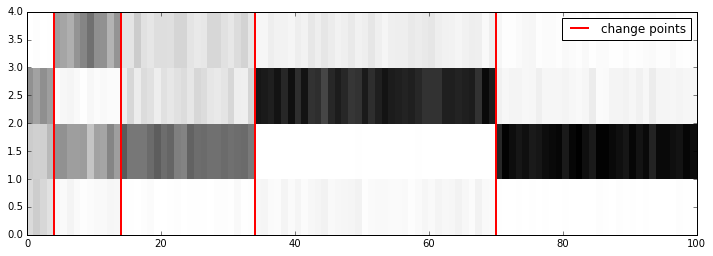

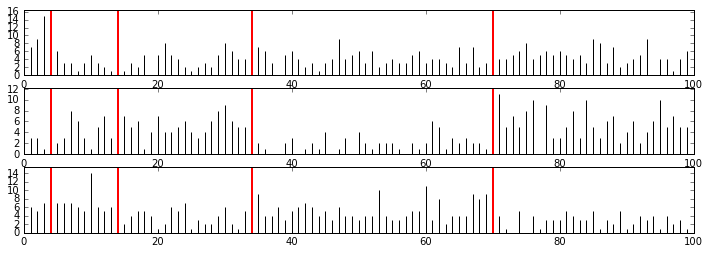

done.


In [152]:
work_dir = '/tmp/demo'
find_or_create(work_dir)

# Generate Model
t = 100
p1 = 0.05
m = 4
n = 3
model = Model.default_model(p1, m, n)
model.save(work_dir + '/model.txt')

# Generate Data
data = model.generate_data(t)
data.save(work_dir + '/data')

# Change Point Estimations
print('filtering...')
result_f = model.filter(data.v)
result_f.save(work_dir + '/filtering')

print('smoothing...')
result_s = model.smooth(data.v)
result_s.save(work_dir + '/smoothing')

print('online smoothing...')
result_o = model.online_smooth(data.v, lag=10)
result_o.save(work_dir + '/online_smoothing')

# Visualization
visualize_data(work_dir + '/data', m, n)

print('done.')

### Python & C++ Comparison

In [148]:
import unittest

bcpm_root = "/home/cagatay/Dropbox/Academic_Stuff/MyGithubRepos/bcpm/"

os.system("(cd " + bcpm_root + "/cpp/bin/; ./runner)")

result_f_cpp = Result.load(work_dir+"/filtering_cpp")
np.testing.assert_array_almost_equal(result_f_cpp.cpp, result_f.cpp)

result_s_cpp = Result.load(work_dir+"/smoothing_cpp")
np.testing.assert_array_almost_equal(result_s_cpp.cpp, result_s.cpp)

result_o_cpp = Result.load(work_dir+"/online_smoothing_cpp")
np.testing.assert_array_almost_equal(result_o_cpp.cpp, result_o.cpp)

### Testing

In [104]:
import unittest

class TestUtils(unittest.TestCase):

    def test_load_save(self):
        x = np.random.rand(4, 5)
        save_txt('/tmp/x.txt', x)
        y = load_txt('/tmp/x.txt')
        np.testing.assert_array_almost_equal(x, y)

    def test_gammaln(self):
        v = np.asarray([1, 2, 3, 4, 5])
        gammaln_v = np.asarray([0, 0, 0.693147, 1.791759, 3.178053])
        np.testing.assert_array_almost_equal(gammaln(v), gammaln_v)

    def test_normalize(self):
        v = np.asarray([1, 2, 3, 4, 5])
        nv = np.asarray([0.066667, 0.133333, 0.2, 0.266667, 0.333333])
        np.testing.assert_array_almost_equal(normalize(v), nv)

    def test_normalize_exp(self):
        v = np.asarray([1, 2, 3, 4, 5])
        log_v = np.log(v)
        np.testing.assert_array_almost_equal(normalize(v), normalize_exp(log_v))

    def test_log_sum_exp(self):
        v = np.asarray([1, 2, 3, 4, 5])
        np.testing.assert_array_almost_equal(log_sum_exp(v), np.log(np.sum(np.exp(v))))

    def test_psi(self):
        v = np.asarray([1, 2, 3, 4, 5])
        psi_v = np.asarray([-0.57721566, 0.42278434, 0.92278434, 1.25611767, 1.50611767])
        np.testing.assert_array_almost_equal(psi(v), psi_v)

    def test_inv_psi(self):
        for x in [1e-6, 0.1, 1, 2, 1000]:
            np.testing.assert_almost_equal(x, inv_psi(psi(x)))


class TestDataMethods(unittest.TestCase):

    def test_load_save(self):
        t = 100
        d = 5
        data = Data(np.zeros(t), np.random.rand(t, d), np.random.rand(t, d))
        data.save('/tmp/data/')
        data2 = Data.load('/tmp/data/')
        np.testing.assert_array_almost_equal(data.s, data2.s)
        np.testing.assert_array_almost_equal(data.h, data2.h)
        np.testing.assert_array_almost_equal(data.v, data2.v)


class TestModelMethods(unittest.TestCase):

    def test_load_save(self):
        m = Model(0.01, [1, 1, 1, 1], [10, 10, 10], [1, 1, 1])
        m.save('/tmp/model1.txt')
        m2 = Model.load('/tmp/model1.txt')
        self.assertEqual(m.p1, m2.p1)
        np.testing.assert_array_almost_equal_nulp(m.prior.alpha, m2.prior.alpha)
        np.testing.assert_array_almost_equal_nulp(m.prior.a, m2.prior.a)
        np.testing.assert_array_almost_equal_nulp(m.prior.b, m2.prior.b)

    def test_generate_data(self):
        t = 100
        # Generate Dirichlet only
        m = Model(0.1, [1, 1, 1], [], [])
        data = m.generate_data(t)
        data.save('/tmp/data1')

        # Generate Gamma only
        m2 = Model(0.1, [], [10, 10], [1, 1])
        data2 = m2.generate_data(t)
        data2.save('/tmp/data2')

        # Generate Coupled
        m3 = Model(0.1, [1, 1, 1, 1], [10, 10], [1, 1])
        data3 = m3.generate_data(t)
        data3.save('/tmp/data3')


class TestPotential(unittest.TestCase):

    def test_deepcopy(self):
        p1 = Potential.default(3, 2)
        p2 = p1.copy()

        p2.alpha = np.asarray([1, 2, 3])
        p2.a = np.asarray([6, 7])
        p2.b = np.asarray([2, 3])
        p2.log_c = 2
        self.assertNotEqual(p1.log_c, p2.log_c)

    def test_comparison(self):
        p1 = Potential.default(3, 2)
        p2 = Potential.default(3, 2)
        p2.log_c = 2
        self.assertTrue(p1 < p2)
        self.assertTrue(p2 > p1)

    def test_multiplication(self):
        # Part 1: Test Dirichlet multiplication
        p1 = Potential([1, 2, 3, 4], [], [])
        p2 = Potential([5, 6, 7, 8], [], [])
        p3 = p1 * p2
        np.testing.assert_almost_equal(p3.log_c, 2.62466487)
        np.testing.assert_array_almost_equal(p3.alpha, np.asarray([5, 7, 9, 11]))

        # Part 2: Test Gamma multiplication
        p1 = Potential([], [10], [1])
        p2 = Potential([], [5], [2])
        p3 = p1 * p2
        np.testing.assert_almost_equal(p3.log_c, -2.56996487)
        np.testing.assert_almost_equal(p3.a, 14)
        np.testing.assert_almost_equal(p3.b, 0.66666667)

        # Part 2: Test Coupled multiplication
        p1 = Potential([1, 2, 3, 4], [10], [1])
        p2 = Potential([5, 6, 7, 8], [5], [2])
        p3 = p1 * p2
        np.testing.assert_almost_equal(p3.log_c, 2.62466487 - 2.56996487)
        np.testing.assert_array_almost_equal(p3.alpha, np.asarray([5, 7, 9, 11]))
        np.testing.assert_almost_equal(p3.a, 14)
        np.testing.assert_almost_equal(p3.b, 0.66666667)

    def test_from_observation(self):
        obs = np.concatenate((normalize([2, 3, 4, 5]), [7]))
        p = Potential.from_observation(obs, 4, 1)
        np.testing.assert_array_almost_equal(p.alpha, np.asarray([1.142857, 1.214286, 1.285714, 1.357143]))
        np.testing.assert_almost_equal(p.log_c, -3.17805383)
        np.testing.assert_almost_equal(p.a, 8)
        np.testing.assert_almost_equal(p.b, 1)

    def test_mean(self):
        p = Potential([1, 2, 3, 4], [10], [1])
        np.testing.assert_array_almost_equal(p.mean(), np.asarray([0.1, 0.2, 0.3, 0.4, 10]))

    def test_ss(self):
        p = Potential([1, 2, 3, 4], [10], [1])
        ss = np.asarray([])
        np.testing.assert_array_almost_equal(p.get_ss(), ss)

    def test_rand_and_fit(self):
        p = Potential([1, 2, 3, 4], [10, 5], [1, 2])
        n = 1000
        x = np.zeros((n, 6))
        for i in range(n):
            x[i, :] = p.rand()
        ss1 = np.mean(np.log(x[:, 0:4]), axis=0)
        ss2 = np.concatenate((np.mean(x[:, 4:6], axis=0), np.mean(np.log(x[:, 4:6]), axis=0)))
        ss = np.concatenate((ss1, ss2))
        p2 = Potential.default(4,2)
        p2 = p.copy()
        p2.fit(ss)

if __name__ == '__main__':
    unittest.main()

E
ERROR: /run/user/1000/jupyter/kernel-b7414a71-d09f-41ad-90d3-a9e0f717e65c (unittest.loader._FailedTest)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute '/run/user/1000/jupyter/kernel-b7414a71-d09f-41ad-90d3-a9e0f717e65c'

----------------------------------------------------------------------
Ran 1 test in 0.001s

FAILED (errors=1)


SystemExit: True

To exit: use 'exit', 'quit', or Ctrl-D.
